In [1]:
# ===========================================
# 初始设置和数据加载
# ===========================================

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
import helpers as ph
import ast
import re

# 设置专业图表样式
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# 定义专业配色方案
PROFESSIONAL_COLORS = {
    'AI21_Labs': '#2E86AB',  # 深蓝色
    'OpenAI': '#A23B72',     # 深紫色
    'confidence': '#4CB5AE',  # 蓝绿色
    'accuracy': '#F18F01',   # 橙色
    'perfect': '#2F2D2E',    # 深灰色
    'histogram': '#C5D86D'   # 浅绿色
}

# 设置字体和尺寸
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

# 配置参数
RESULTS_DIR = './data/distributions/'
CONTEXT = 'default'
SAVEFIG = True

# 加载数据
combined_df = []
for wave in ph.PEW_SURVEY_LIST:
    SURVEY_NAME = f'American_Trends_Panel_W{wave}'
    cdf = pd.read_csv(os.path.join(RESULTS_DIR, f'{SURVEY_NAME}_{CONTEXT}_combined.csv'))
    cdf['survey'] = f'ATP {wave}'
    combined_df.append(cdf)
combined_df = pd.concat(combined_df)
combined_df['Source'] = combined_df.apply(lambda x: 'AI21 Labs' if 'j1-' in x['model_name'].lower() else 'OpenAI', axis=1)

print(f"已加载 {len(combined_df)} 行数据")
print(f"数据列: {combined_df.columns.tolist()}")

已加载 825120 行数据
数据列: ['Unnamed: 0', 'input_id', 'question_raw', 'question', 'references', 'context', 'mapping', 'top_k_logprobs', 'logprobs', 'probs_unnorm', 'probs_norm', 'misses', 'D_M', 'R_M', 'ordinal', 'ordinal_refs', 'refusal_refs', 'qkey', 'results_path', 'context_type', 'model_name', 'model_order', 'attribute', 'group', 'D_H', 'R_H', 'group_order', 'WD', 'survey', 'Source']


In [2]:
# ===========================================
# 数据解析函数
# ===========================================

def safe_parse_distribution(dist):
    """安全解析分布数据，处理多种格式"""
    if isinstance(dist, list):
        return dist
    elif isinstance(dist, str):
        dist = dist.strip()
        if not dist:
            return []
        try:
            if dist.startswith('[') and dist.endswith(']'):
                try:
                    return ast.literal_eval(dist)
                except:
                    content = dist[1:-1].strip()
                    if ',' in content:
                        return [float(x.strip()) for x in content.split(',') if x.strip()]
                    else:
                        return [float(x) for x in content.split() if x]
            elif ' ' in dist:
                return [float(x) for x in dist.split() if x]
            elif ',' in dist:
                return [float(x.strip()) for x in dist.split(',') if x.strip()]
            else:
                return [float(dist)]
        except Exception as e:
            print(f"警告: 无法解析分布数据: {repr(dist)}")
            print(f"错误: {e}")
            return []
    elif isinstance(dist, np.ndarray):
        return dist.tolist()
    else:
        print(f"警告: 未知分布类型: {type(dist)}")
        return []

# 测试解析函数
test_cases = [
    "[0.27070319 0.24841121 0.29042213 0.19046348]",
    "[0.27070319, 0.24841121, 0.29042213, 0.19046348]",
    [0.27070319, 0.24841121, 0.29042213, 0.19046348],
    "0.27070319 0.24841121 0.29042213 0.19046348",
    "0.27070319,0.24841121,0.29042213,0.19046348",
    ""
]

print("测试解析函数:")
for i, test in enumerate(test_cases):
    result = safe_parse_distribution(test)
    print(f"测试 {i+1}: {repr(test)} -> {result}")

测试解析函数:
测试 1: '[0.27070319 0.24841121 0.29042213 0.19046348]' -> [0.27070319, 0.24841121, 0.29042213, 0.19046348]
测试 2: '[0.27070319, 0.24841121, 0.29042213, 0.19046348]' -> [0.27070319, 0.24841121, 0.29042213, 0.19046348]
测试 3: [0.27070319, 0.24841121, 0.29042213, 0.19046348] -> [0.27070319, 0.24841121, 0.29042213, 0.19046348]
测试 4: '0.27070319 0.24841121 0.29042213 0.19046348' -> [0.27070319, 0.24841121, 0.29042213, 0.19046348]
测试 5: '0.27070319,0.24841121,0.29042213,0.19046348' -> [0.27070319, 0.24841121, 0.29042213, 0.19046348]
测试 6: '' -> []


In [3]:
# ===========================================
# ECE计算函数
# ===========================================

def calculate_ece(model_probs, human_probs, n_bins=10):
    """计算预期校准误差(ECE)"""
    model_flat = np.concatenate(model_probs)
    human_flat = np.concatenate(human_probs)
    
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(model_flat, bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    ece = 0.0
    bin_stats = []
    
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            bin_conf = np.mean(model_flat[mask])
            bin_acc = np.mean(human_flat[mask])
            bin_weight = np.sum(mask) / len(model_flat)
            bin_ece = bin_weight * np.abs(bin_conf - bin_acc)
            ece += bin_ece
            
            bin_stats.append({
                'bin': i,
                'bin_start': bin_edges[i],
                'bin_end': bin_edges[i+1],
                'confidence': bin_conf,
                'accuracy': bin_acc,
                'count': np.sum(mask),
                'weight': bin_weight,
                'ece_contribution': bin_ece
            })
    
    return ece, bin_stats

def calculate_model_ece(combined_data, n_bins=10):
    """为每个模型计算所有问题的ECE"""
    model_ece_results = []
    
    for model_name in combined_data['model_name'].unique():
        model_data = combined_data[combined_data['model_name'] == model_name]
        
        model_probs = []
        human_probs = []
        
        for _, row in model_data.iterrows():
            d_m = safe_parse_distribution(row['D_M'])
            d_h = safe_parse_distribution(row['D_H'])
            
            if len(d_m) > 0 and len(d_h) > 0:
                model_probs.append(d_m)
                human_probs.append(d_h)
        
        if len(model_probs) > 0:
            ece, bin_stats = calculate_ece(model_probs, human_probs, n_bins)
            
            model_ece_results.append({
                'model_name': model_name,
                'source': 'AI21 Labs' if 'j1-' in model_name.lower() else 'OpenAI',
                'ece': ece,
                'n_questions': len(model_data),
                'n_valid_questions': len(model_probs),
                'bin_stats': bin_stats
            })
        else:
            print(f"警告: 模型 {model_name} 没有有效数据")
    
    return pd.DataFrame(model_ece_results)

# 计算ECE
print("正在为所有模型计算ECE...")
ece_results = calculate_model_ece(combined_df)
ece_results = ece_results.sort_values('ece')

print("\nECE结果 (越低越好):")
for _, row in ece_results.iterrows():
    print(f"{row['model_name']:30} ECE: {row['ece']:.4f} (基于 {row['n_valid_questions']} 个问题)")

正在为所有模型计算ECE...

ECE结果 (越低越好):
j1-grande                      ECE: 0.0377 (基于 91680 个问题)
ada                            ECE: 0.0452 (基于 91680 个问题)
j1-jumbo                       ECE: 0.0636 (基于 91680 个问题)
j1-grande-v2-beta              ECE: 0.0940 (基于 91680 个问题)
davinci                        ECE: 0.1170 (基于 91680 个问题)
text-davinci-002               ECE: 0.1949 (基于 91680 个问题)
text-ada-001                   ECE: 0.2421 (基于 91680 个问题)
text-davinci-001               ECE: 0.2543 (基于 91680 个问题)
text-davinci-003               ECE: 0.3010 (基于 91680 个问题)


/tmp/ipykernel_1501/2127419321.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax2.boxplot(source_data, labels=source_labels,


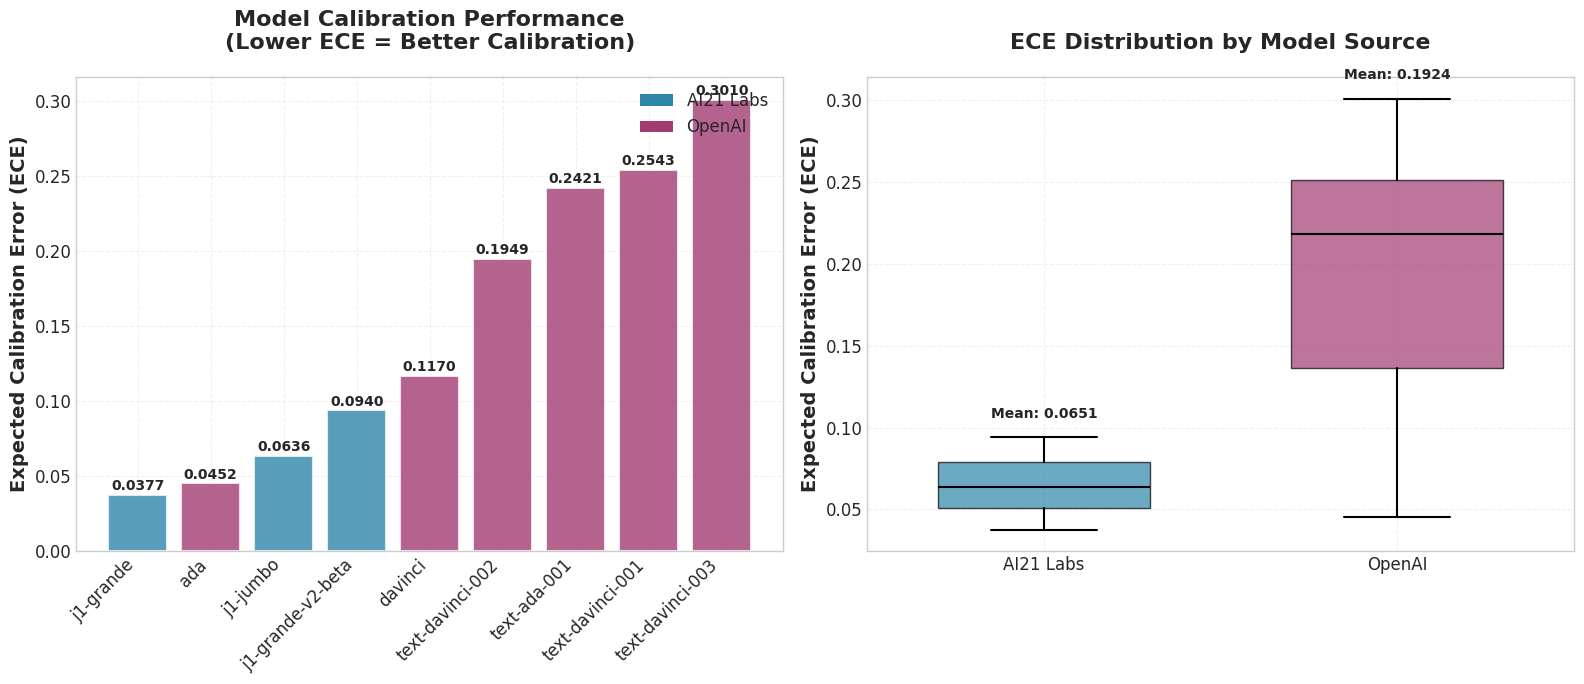

In [4]:
# ===========================================
# 1. 美化版ECE比较图
# ===========================================

def create_ece_comparison_plot(ece_results, save_path=None):
    """创建专业版的ECE比较图"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # 图1: ECE柱状图
    colors = [PROFESSIONAL_COLORS['AI21_Labs'] if 'AI21' in source else PROFESSIONAL_COLORS['OpenAI'] 
              for source in ece_results['source']]
    
    bars = ax1.bar(range(len(ece_results)), ece_results['ece'], 
                   color=colors, alpha=0.8, 
                   edgecolor='white', linewidth=1.5)
    
    # 设置x轴标签和标题
    ax1.set_xticks(range(len(ece_results)))
    ax1.set_xticklabels(ece_results['model_name'], rotation=45, ha='right')
    ax1.set_ylabel('Expected Calibration Error (ECE)', fontweight='bold')
    ax1.set_title('Model Calibration Performance\n(Lower ECE = Better Calibration)', 
                  fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # 在柱子上添加数值标签
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                 f'{height:.4f}', ha='center', va='bottom', 
                 fontsize=10, fontweight='bold')
    
    # 添加图例
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=PROFESSIONAL_COLORS['AI21_Labs'], label='AI21 Labs'),
        Patch(facecolor=PROFESSIONAL_COLORS['OpenAI'], label='OpenAI')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    # 图2: ECE箱线图
    source_data = []
    source_labels = []
    
    for source in ece_results['source'].unique():
        source_ece = ece_results[ece_results['source'] == source]['ece'].values
        source_data.append(source_ece)
        source_labels.append(source)
    
    box_colors = [PROFESSIONAL_COLORS['AI21_Labs'], PROFESSIONAL_COLORS['OpenAI']]
    
    box_plot = ax2.boxplot(source_data, labels=source_labels, 
                          patch_artist=True,
                          widths=0.6)
    
    for patch, color in zip(box_plot['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # 设置箱线图样式
    for element in ['whiskers', 'caps', 'medians']:
        plt.setp(box_plot[element], color='black', linewidth=1.5)
    
    plt.setp(box_plot['fliers'], marker='o', color='red', alpha=0.8)
    
    ax2.set_ylabel('Expected Calibration Error (ECE)', fontweight='bold')
    ax2.set_title('ECE Distribution by Model Source', fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    # 添加统计信息
    for i, data in enumerate(source_data):
        mean_val = np.mean(data)
        ax2.text(i+1, np.max(data) + 0.01, f'Mean: {mean_val:.4f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300, 
                   facecolor='white', edgecolor='none')
    
    plt.show()

# 使用美化版函数
create_ece_comparison_plot(ece_results, './figures/ece_comparison_beautified.png')

In [5]:
# ===========================================
# 2. 美化版可靠性图
# ===========================================

def create_reliability_diagram(model_name, bin_stats, ax):
    """创建专业版的可靠性图"""
    
    confidences = [stat['confidence'] for stat in bin_stats]
    accuracies = [stat['accuracy'] for stat in bin_stats]
    counts = [stat['count'] for stat in bin_stats]
    
    # 绘制完美校准参考线
    ax.plot([0, 1], [0, 1], '--', color=PROFESSIONAL_COLORS['perfect'], 
            alpha=0.8, linewidth=2, label='Perfect Calibration')
    
    # 绘制可靠性曲线
    ax.plot(confidences, accuracies, 'o-', linewidth=3, markersize=8, 
            color=PROFESSIONAL_COLORS['AI21_Labs'], 
            markerfacecolor='white', markeredgewidth=2,
            label=f'{model_name}')
    
    # 添加样本数量直方图
    ax2 = ax.twinx()
    bin_centers = [(stat['bin_start'] + stat['bin_end']) / 2 for stat in bin_stats]
    
    ax2.bar(bin_centers, counts, alpha=0.4, width=0.08, 
            color=PROFESSIONAL_COLORS['histogram'], 
            label='Sample Count')
    ax2.set_ylabel('Number of Samples', fontweight='bold')
    
    # 设置轴标签和标题
    ax.set_xlabel('Predicted Confidence', fontweight='bold')
    ax.set_ylabel('Actual Accuracy', fontweight='bold')
    ax.set_title(f'Reliability Diagram: {model_name}', fontweight='bold', pad=20)
    
    # 设置网格和范围
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # 添加图例
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

def create_reliability_dashboard(ece_results, save_path=None):
    """创建可靠性图仪表板"""
    
    n_models = min(4, len(ece_results))
    
    # 动态调整子图布局
    if n_models <= 2:
        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 确保axes是二维数组
    if n_models == 1:
        axes = [axes]
    elif n_models == 2:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # 为每个模型创建可靠性图
    for i in range(n_models):
        model_row = ece_results.iloc[i]
        create_reliability_diagram(model_row['model_name'], 
                                 model_row['bin_stats'], axes[i])
    
    # 隐藏多余的子图
    for i in range(n_models, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300,
                   facecolor='white', edgecolor='none')
    
    plt.show()

# 使用美化版函数
create_reliability_dashboard(ece_results, './figures/reliability_diagrams_beautified.png')

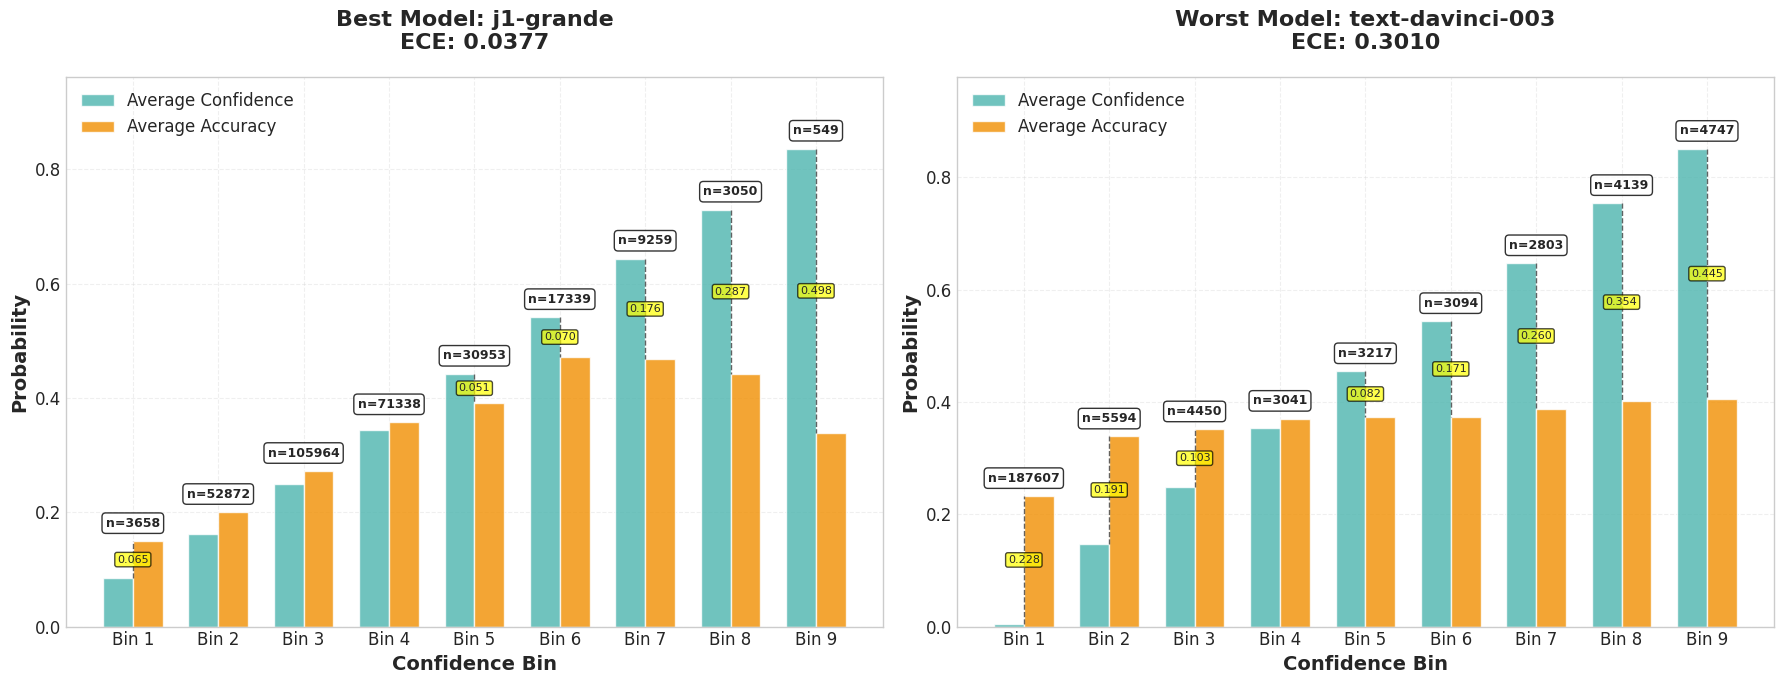

In [6]:
# ===========================================
# 3. 美化版校准直方图
# ===========================================

def create_calibration_comparison(best_model, worst_model, ece_results, save_path=None):
    """创建专业版的校准比较图"""
    
    # 获取模型数据
    best_stats = ece_results[ece_results['model_name'] == best_model]['bin_stats'].iloc[0]
    worst_stats = ece_results[ece_results['model_name'] == worst_model]['bin_stats'].iloc[0]
    
    # 确保相同数量的桶
    n_bins = min(len(best_stats), len(worst_stats))
    best_stats = best_stats[:n_bins]
    worst_stats = worst_stats[:n_bins]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # 最佳模型
    plot_calibration_histogram_panel(ax1, best_stats, best_model, 
                                   ece_results[ece_results['model_name'] == best_model]['ece'].iloc[0],
                                   'Best Model')
    
    # 最差模型
    plot_calibration_histogram_panel(ax2, worst_stats, worst_model,
                                   ece_results[ece_results['model_name'] == worst_model]['ece'].iloc[0],
                                   'Worst Model')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300,
                   facecolor='white', edgecolor='none')
    
    plt.show()

def plot_calibration_histogram_panel(ax, bin_stats, model_name, ece_value, panel_title):
    """绘制单个校准直方图面板"""
    
    confidences = [stat['confidence'] for stat in bin_stats]
    accuracies = [stat['accuracy'] for stat in bin_stats]
    counts = [stat['count'] for stat in bin_stats]
    
    width = 0.35
    x_pos = np.arange(len(confidences))
    
    # 绘制置信度和准确率柱状图
    bars1 = ax.bar(x_pos - width/2, confidences, width, 
                   label='Average Confidence', 
                   color=PROFESSIONAL_COLORS['confidence'],
                   alpha=0.8, edgecolor='white', linewidth=1)
    
    bars2 = ax.bar(x_pos + width/2, accuracies, width, 
                   label='Average Accuracy', 
                   color=PROFESSIONAL_COLORS['accuracy'],
                   alpha=0.8, edgecolor='white', linewidth=1)
    
    # 设置标签和标题
    ax.set_xlabel('Confidence Bin', fontweight='bold')
    ax.set_ylabel('Probability', fontweight='bold')
    ax.set_title(f'{panel_title}: {model_name}\nECE: {ece_value:.4f}', 
                 fontweight='bold', pad=20)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'Bin {i+1}' for i in range(len(confidences))])
    ax.legend()
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # 设置y轴范围
    ax.set_ylim(0, max(max(confidences), max(accuracies)) * 1.15)
    
    # 添加样本数量标签
    for i, count in enumerate(counts):
        ax.text(i, max(confidences[i], accuracies[i]) + 0.02, 
                f'n={count}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # 添加校准差距线
    for i, (conf, acc) in enumerate(zip(confidences, accuracies)):
        gap = abs(conf - acc)
        if gap > 0.05:  # 只显示显著差距
            ax.plot([i, i], [conf, acc], 'k--', alpha=0.6, linewidth=1)
            ax.text(i, (conf + acc) / 2, f'{gap:.3f}', 
                    ha='center', va='center', fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.2", facecolor="yellow", alpha=0.7))

# 使用美化版函数
if len(ece_results) > 1:
    best_model = ece_results.iloc[0]['model_name']
    worst_model = ece_results.iloc[-1]['model_name']
    
    create_calibration_comparison(best_model, worst_model, ece_results,
                                './figures/calibration_comparison_beautified.png')

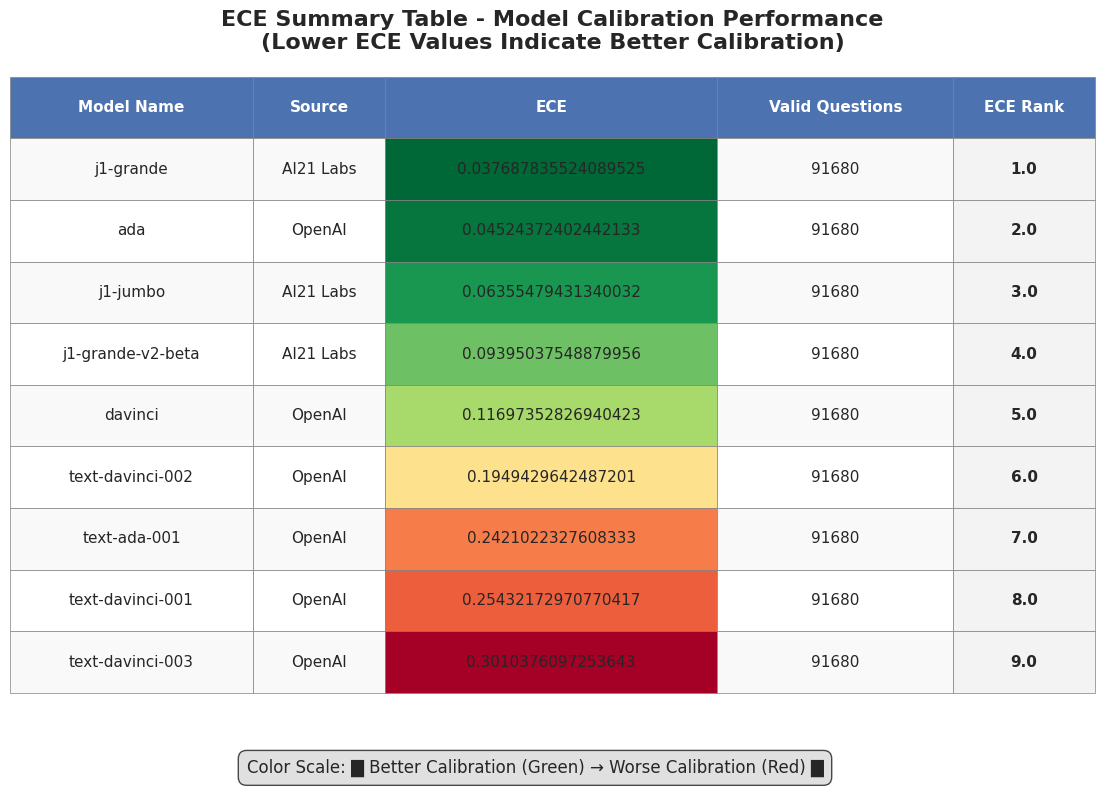

In [7]:
# ===========================================
# 4. 美化版总结表格
# ===========================================

def create_professional_summary_table(ece_results, save_path=None):
    """创建专业版的总结表格"""
    
    # 准备数据
    summary_df = ece_results[['model_name', 'source', 'ece', 'n_valid_questions']].copy()
    summary_df['ece_rank'] = summary_df['ece'].rank()
    summary_df = summary_df.sort_values('ece_rank')
    
    # 重命名列以更专业
    summary_df.columns = ['Model Name', 'Source', 'ECE', 'Valid Questions', 'ECE Rank']
    
    # 创建matplotlib表格
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')
    
    # 创建表格
    table = ax.table(cellText=summary_df.values,
                     colLabels=summary_df.columns,
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    
    # 设置表格样式
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 1.8)
    
    # 设置列宽
    for i in range(len(summary_df.columns)):
        table.auto_set_column_width([i])
    
    # 设置标题行样式
    for j in range(len(summary_df.columns)):
        table[(0, j)].set_facecolor('#4C72B0')
        table[(0, j)].set_text_props(weight='bold', color='white')
    
    # 为ECE列添加颜色渐变
    ece_values = summary_df['ECE'].values
    norm = plt.Normalize(ece_values.min(), ece_values.max())
    ece_col_idx = summary_df.columns.get_loc('ECE')
    
    for i in range(len(summary_df)):
        # ECE列颜色
        ece_color = plt.cm.RdYlGn_r(norm(ece_values[i]))
        table[(i+1, ece_col_idx)].set_facecolor(ece_color)
        
        # 排名列样式
        rank_col_idx = summary_df.columns.get_loc('ECE Rank')
        table[(i+1, rank_col_idx)].set_facecolor('#F3F3F3')
        table[(i+1, rank_col_idx)].set_text_props(weight='bold')
        
        # 交替行颜色
        if i % 2 == 0:
            for j in range(len(summary_df.columns)):
                if j not in [ece_col_idx, rank_col_idx]:
                    table[(i+1, j)].set_facecolor('#F9F9F9')
    
    # 设置所有单元格边框
    for key, cell in table.get_celld().items():
        cell.set_edgecolor('gray')
        cell.set_linewidth(0.5)
    
    # 添加标题
    plt.title('ECE Summary Table - Model Calibration Performance\n(Lower ECE Values Indicate Better Calibration)', 
              fontsize=16, fontweight='bold', pad=20)
    
    # 添加图例说明
    legend_text = "Color Scale: █ Better Calibration (Green) → Worse Calibration (Red) █"
    plt.figtext(0.5, 0.01, legend_text, ha='center', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.7))
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300,
                   facecolor='white', edgecolor='none')
    
    plt.show()
    
    return summary_df

# 使用美化版函数
professional_summary = create_professional_summary_table(ece_results, 
                                                        './figures/ece_summary_table_beautified.png')

/tmp/ipykernel_1501/1677005932.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax2.boxplot(source_data, labels=ece_results['source'].unique(),
/tmp/ipykernel_1501/1677005932.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


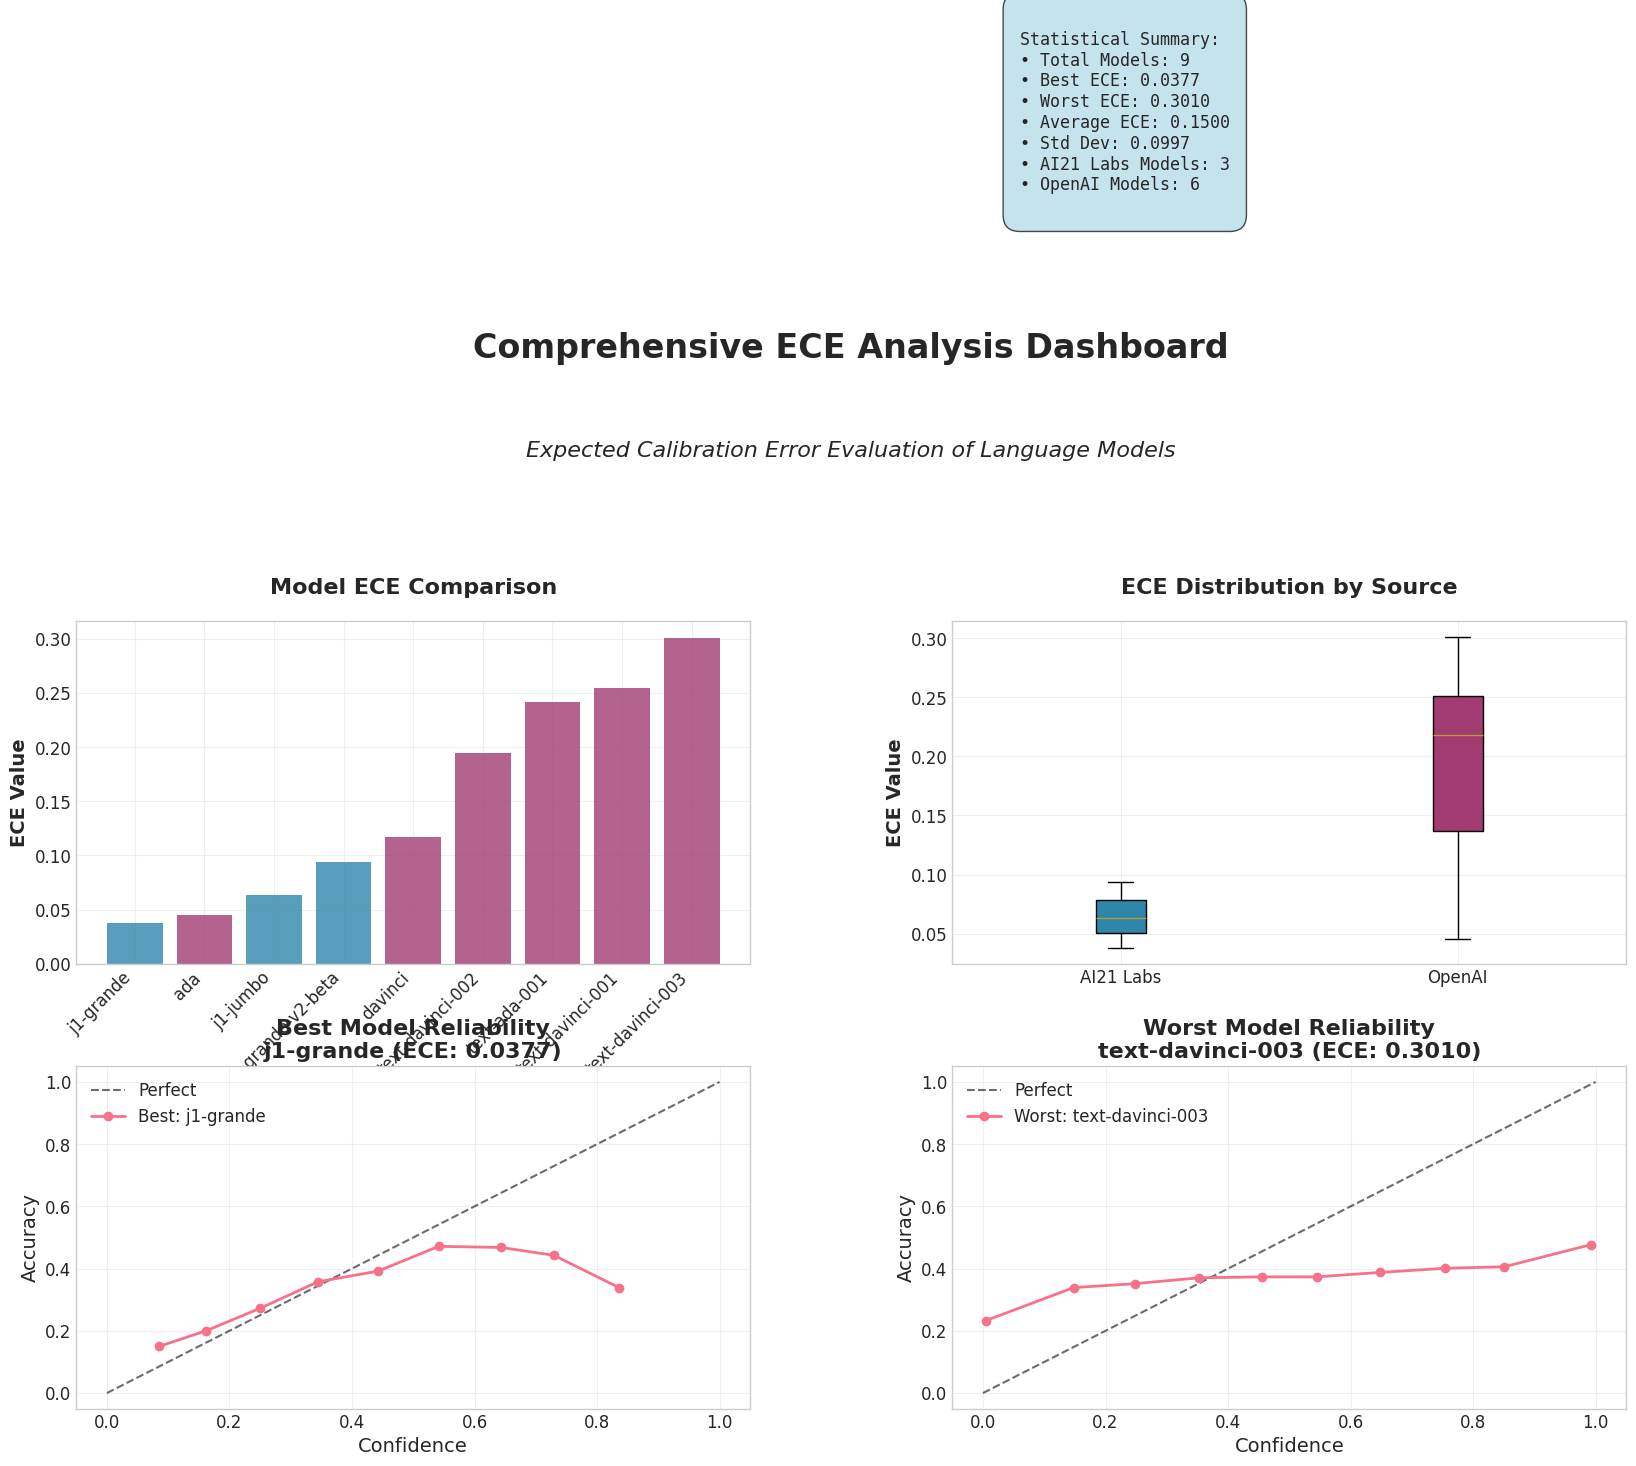

In [8]:
# ===========================================
# 5. 综合仪表板
# ===========================================

def create_comprehensive_dashboard(ece_results, save_path=None):
    """创建综合ECE分析仪表板"""
    
    fig = plt.figure(figsize=(20, 16))
    
    # 创建网格布局
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. 主标题
    ax_title = fig.add_subplot(gs[0, :])
    ax_title.axis('off')
    ax_title.text(0.5, 0.5, 'Comprehensive ECE Analysis Dashboard', 
                  ha='center', va='center', fontsize=24, fontweight='bold')
    ax_title.text(0.5, 0.2, 'Expected Calibration Error Evaluation of Language Models', 
                  ha='center', va='center', fontsize=16, style='italic')
    
    # 2. ECE比较图
    ax1 = fig.add_subplot(gs[1, 0])
    colors = [PROFESSIONAL_COLORS['AI21_Labs'] if 'AI21' in source else PROFESSIONAL_COLORS['OpenAI'] 
              for source in ece_results['source']]
    bars = ax1.bar(range(len(ece_results)), ece_results['ece'], color=colors, alpha=0.8)
    ax1.set_xticks(range(len(ece_results)))
    ax1.set_xticklabels(ece_results['model_name'], rotation=45, ha='right')
    ax1.set_ylabel('ECE Value', fontweight='bold')
    ax1.set_title('Model ECE Comparison', fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)
    
    # 3. 箱线图
    ax2 = fig.add_subplot(gs[1, 1])
    source_data = [ece_results[ece_results['source'] == source]['ece'].values 
                   for source in ece_results['source'].unique()]
    box_plot = ax2.boxplot(source_data, labels=ece_results['source'].unique(), 
                          patch_artist=True)
    for patch, color in zip(box_plot['boxes'], [PROFESSIONAL_COLORS['AI21_Labs'], PROFESSIONAL_COLORS['OpenAI']]):
        patch.set_facecolor(color)
    ax2.set_ylabel('ECE Value', fontweight='bold')
    ax2.set_title('ECE Distribution by Source', fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3)
    
    # 4. 最佳模型可靠性图
    ax3 = fig.add_subplot(gs[2, 0])
    best_model = ece_results.iloc[0]
    best_stats = best_model['bin_stats']
    confidences = [stat['confidence'] for stat in best_stats]
    accuracies = [stat['accuracy'] for stat in best_stats]
    
    ax3.plot([0, 1], [0, 1], '--', color=PROFESSIONAL_COLORS['perfect'], alpha=0.7, label='Perfect')
    ax3.plot(confidences, accuracies, 'o-', linewidth=2, label=f"Best: {best_model['model_name']}")
    ax3.set_xlabel('Confidence')
    ax3.set_ylabel('Accuracy')
    ax3.set_title(f'Best Model Reliability\n{best_model["model_name"]} (ECE: {best_model["ece"]:.4f})', 
                  fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 5. 最差模型可靠性图
    ax4 = fig.add_subplot(gs[2, 1])
    worst_model = ece_results.iloc[-1]
    worst_stats = worst_model['bin_stats']
    confidences = [stat['confidence'] for stat in worst_stats]
    accuracies = [stat['accuracy'] for stat in worst_stats]
    
    ax4.plot([0, 1], [0, 1], '--', color=PROFESSIONAL_COLORS['perfect'], alpha=0.7, label='Perfect')
    ax4.plot(confidences, accuracies, 'o-', linewidth=2, label=f"Worst: {worst_model['model_name']}")
    ax4.set_xlabel('Confidence')
    ax4.set_ylabel('Accuracy')
    ax4.set_title(f'Worst Model Reliability\n{worst_model["model_name"]} (ECE: {worst_model["ece"]:.4f})', 
                  fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 6. 统计摘要
    ax5 = fig.add_subplot(gs[0, 1])
    ax5.axis('off')
    
    stats_text = f"""
Statistical Summary:
• Total Models: {len(ece_results)}
• Best ECE: {ece_results['ece'].min():.4f}
• Worst ECE: {ece_results['ece'].max():.4f}
• Average ECE: {ece_results['ece'].mean():.4f}
• Std Dev: {ece_results['ece'].std():.4f}
• AI21 Labs Models: {len(ece_results[ece_results['source'] == 'AI21 Labs'])}
• OpenAI Models: {len(ece_results[ece_results['source'] == 'OpenAI'])}
    """
    
    ax5.text(0.1, 0.9, stats_text, fontsize=12, fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=1", facecolor="lightblue", alpha=0.7))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300,
                   facecolor='white', edgecolor='none')
    
    plt.show()

# 创建综合仪表板
create_comprehensive_dashboard(ece_results, './figures/ece_comprehensive_dashboard.png')